<a href="https://colab.research.google.com/github/ishaan175pathak/sentiment-analysis-using-RNN-LSTM-and-flask/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import regex as re 
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify


nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
with open("/content/amazon_alexa.tsv",encoding="utf8") as file:
    data = pd.read_csv(file,sep="\t")

In [ ]:
# checking for null values 

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [ ]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
data["verified_reviews"]

0                                           Love my Echo!
1                                               Loved it!
2       Sometimes while playing a game, you can answer...
3       I have had a lot of fun with this thing. My 4 ...
4                                                   Music
                              ...                        
3145    Perfect for kids, adults and everyone in betwe...
3146    Listening to music, searching locations, check...
3147    I do love these things, i have them running my...
3148    Only complaint I have is that the sound qualit...
3149                                                 Good
Name: verified_reviews, Length: 3150, dtype: object

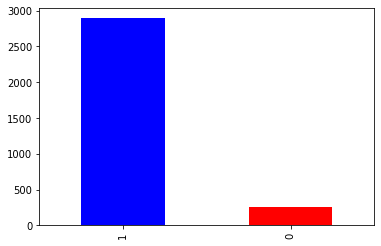

In [ ]:
data["feedback"].value_counts().plot.bar(color = ["blue","red"])

In [ ]:
data["feedback"].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

In [ ]:
  def cleaning(df, stop_words):

      df["verified_reviews"] = df["verified_reviews"].apply(lambda x: " ".join(x.lower() for x in x.split()))

      # Replacing the special characters

      df["verified_reviews"] = df["verified_reviews"].apply(lambda x: " ".join([re.sub("[^A-Za-z0-9]+","",element) for element in str(x).split(" ")]))

      # replacing the digit/numbers

      df["verified_reviews"] = df["verified_reviews"].str.replace('d', '')

      # removing stopwords 

      df["verified_reviews"] = df["verified_reviews"].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
      
      # Encoding target column

      df["feedback"] = LabelEncoder().fit_transform(df["feedback"])

      return df

  stop_words = stopwords.words('english')

  data_modified = cleaning(data, stop_words)


In [ ]:
token = Tokenizer(num_words=500, split=' ')
token.fit_on_texts(data_modified["verified_reviews"].values)
X = token.texts_to_sequences(data["verified_reviews"].values)
X = pad_sequences(X)


In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(500, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 147, 128)          64000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 147, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 319,194
Trainable params: 319,194
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y=pd.get_dummies(data_modified['feedback'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
69/69 [==============================] - 35s 480ms/step - loss: 0.2937 - accuracy: 0.9175
Epoch 2/5
69/69 [==============================] - 34s 494ms/step - loss: 0.2139 - accuracy: 0.9279
Epoch 3/5
69/69 [==============================] - 33s 481ms/step - loss: 0.1445 - accuracy: 0.9469
Epoch 4/5
69/69 [==============================] - 33s 477ms/step - loss: 0.1258 - accuracy: 0.9519
Epoch 5/5
69/69 [==============================] - 33s 478ms/step - loss: 0.1114 - accuracy: 0.9569


In [ ]:
model.evaluate(X_test,y_test)

30/30 [==============================] - 2s 65ms/step - loss: 0.2173 - accuracy: 0.9185


[0.2173299342393875, 0.9185185432434082]